In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scisig
import scipy.optimize as opt
from numba import jit, njit
import time
import scipy.io as sio

from scipy.signal import butter, lfilter

def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='lowpass')
    return b, a


def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='highpass')
    return b, a


def butter_highpass_filter(data, lowcut, fs, order=5):
    b, a = butter_highpass(lowcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def Linewidth2(x, a,  x0, gamma, c): #with noise floor
    return a*(gamma)/((x0**2 - x**2)**2+(x*gamma)**2) + c

def Linewidth(x, a,  x0, gamma): #with noise floor
    return a*(gamma)/((x0**2 - x**2)**2+(x*gamma)**2) 

In [2]:
import random
nump = 2*10**(7)

np.random.seed(1235681)
randomlist = np.random.normal(0, 1, nump) # for thermal force

#seed
np.random.seed(9472518)
randomlist2 = np.random.normal(0, 1, nump) # for thermal force

np.random.seed(83691836)
randomlist3 = np.random.normal(0, 1, nump) # for feedback noise

np.random.seed(173859382)
randomlist4 = np.random.normal(0, 1, nump) # for detection noise

np.random.seed(157391034)
randomlist5 = np.random.normal(0, 1, nump) # for detection noise

In [3]:
@njit
def leapfrog_thermal(i, buf, y1, y2, w01, w02, Fth1, Fth2, M1, M2, Q1, Q2, dt, rnd1, rnd2, separation):
    # i is iteration we are on
    # x0 and v0 are initial position and velocity for this step
    # dt is timestep size
    # rnd is random number for this timestep
    tmpbuf = np.zeros(4)
    
    xint1 = buf[0] + 0.5*buf[1]*dt
    xint2 = buf[2] + 0.5*buf[3]*dt
    offset = separation/2
    v1 = buf[1]*(1 - y1*dt) + Fth1*rnd1*dt - w01**2*(xint1-offset)*dt - dt*1/M1/4/np.pi/e0*(Q1*Q2)/(xint2-xint1)**2
    x1 = xint1 + 0.5*v1*dt
    
    v2 = buf[3]*(1 - y2*dt) + Fth2*rnd2*dt - w02**2*(xint2+offset)*dt + dt*1/M2/4/np.pi/e0*(Q1*Q2)/(xint2-xint1)**2
    x2 = xint2 + 0.5*v2*dt
    
    tmpbuf[0] = x1
    tmpbuf[1] = v1
    tmpbuf[2] = x2
    tmpbuf[3] = v2
    return tmpbuf

@njit
def loop_itth(n, y1, y2, w01, w02, Fth1, Fth2, M1, M2, Q1, Q2, dtn, randomlist, randomlist2, separation):
    buf = np.array([separation/2, 0, -separation/2, 0])
    xl1 = np.zeros(n)
    vl1 = np.zeros(n)
    xl2 = np.zeros(n)
    vl2 = np.zeros(n)
    for i in range(n):
        buf = leapfrog_thermal(i, buf, y1, y2, w01, w02, Fth1, Fth2, M1, M2, Q1, Q2, dtn, randomlist[i], randomlist2[i], separation)
        xl1[i] = buf[0]
        vl1[i] = buf[1]
        xl2[i] = buf[2]
        vl2[i] = buf[3]
    return xl1, vl1, xl2, vl2

In [6]:
# User set variables
P = 3*10**(0) # Pressure in mbar
T = 293 # Environmental temperature
alpha = (1)**(1/3) # Ratio of particle masses
R1 = (5000)*10**(-9) # Particle Radius
R2 = (alpha**(1/3))*R1 # Particle Radius
p = 1850 # Particle Denisty
dtn = 5*10**(-5) # Timestep
nump = 2*10**6 # Number of points

# Other Variables
M1 = 4/3*np.pi*R1**3*p # Particle mass
M2 = 4/3*np.pi*R2**3*p # Particle mass
kb = 1.38*10**(-23) # Boltzmann constant
m = 29*1.67*10**(-27) # average mass of air particles
v = np.sqrt(8*1.38*10**(-23)*T/(np.pi*m)) # velocity of air particles
N0 = 2.43*10**(25) # Number density of air and ambient pressure
P0 = 1000 # Ambient pressure
N=N0*P/P0 # Number density of air at pressure P
#y = (4/3*np.pi)*(m*v*N*Reff**2)/(M) # Damping from air
y1 = 4.10568*1e-6*P*1e2/R1 # Antonio's damping from air
y2 = 4.10568*1e-6*P*1e2/R2 # Antonio's damping from air
Fth1 =  np.sqrt(2*kb*T*y1/M1/dtn)# Thermal force noise
Fth2 =  np.sqrt(2*kb*T*y2/M2/dtn)# Thermal force noise
Q1 = 1000*1.6*10**(-19) # Charge
Q2 = 1000*1.6*10**(-19) # Charge
w01 = 100*2*np.pi # Frequency
w02 = 100*2*np.pi # Frequency

sep = 75*10**(-6) # Separation

print(w01/2/np.pi)
print(w02/2/np.pi)

100.0
100.0


In [7]:
x1l, v1l, x2l, v2l = loop_itth(nump, y1, y2, w01, w02, Fth1, Fth2, M1, M2, Q1, Q2, dtn, randomlist, randomlist2, sep)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1mNameError: name 'e0' is not defined[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function leapfrog_thermal at 0x000001CC32B85E50>))[0m
[0m[1mDuring: typing of call at C:\Users\Ben\AppData\Local\Temp/ipykernel_12260/1488981223.py (32)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function leapfrog_thermal at 0x000001CC32B85E50>))[0m
[0m[1mDuring: typing of call at C:\Users\Ben\AppData\Local\Temp/ipykernel_12260/1488981223.py (32)
[0m
[1m
File "..\..\AppData\Local\Temp\ipykernel_12260\1488981223.py", line 32:[0m
[1m<source missing, REPL/exec in use?>[0m


In [8]:
lb = 0
ub = 10000
plt.plot(x1l[lb:ub])
plt.plot(x2l[lb:ub])

NameError: name 'x1l' is not defined

In [81]:
inttime = 1
PSD1 = scisig.welch(x1l, fs = 1/dtn, nperseg = 1/dtn)
PSD2 = scisig.welch(x2l, fs = 1/dtn, nperseg = 1/dtn)

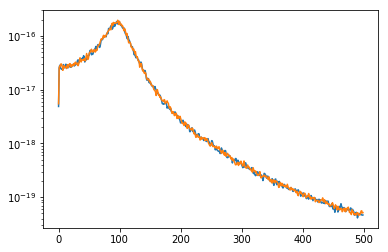

In [82]:
lb = 0
ub = 500
plt.plot(PSD1[0][lb:ub], PSD1[1][lb:ub])
plt.plot(PSD2[0][lb:ub], PSD2[1][lb:ub])
plt.yscale('log')